In [24]:
%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import graphviz
from IPython.display import display
import seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# PREPARING THE DATASETS

In [25]:
bc_file_path = 'wdbc.data'

column_names = [
    'ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
    'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

breast_cancer_df = pd.read_csv(bc_file_path, header=None, names=column_names)


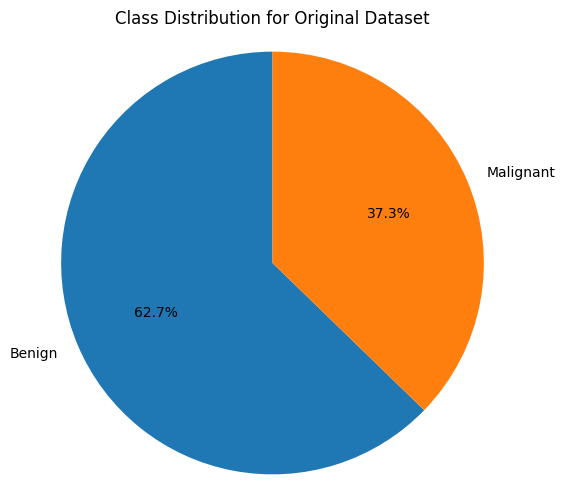

In [26]:
feature_names = breast_cancer_df.drop(columns=['ID', 'Diagnosis']).columns.tolist()
features = breast_cancer_df.drop(columns=['ID', 'Diagnosis']).values
label_names = ['Benign', 'Malignant']
labels = breast_cancer_df['Diagnosis'].map({'B': 0, 'M': 1}).values

# Visualize the class distribution in the original dataset
plt.figure(figsize=(6, 6))
plt.pie(np.bincount(labels, minlength=2), labels=label_names, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution for Original Dataset")
plt.axis('equal') 
plt.show()

In [27]:
split_ratio = {
    "40/60": 0.6,
    "60/40": 0.4,
    "80/20": 0.2,
    "90/10": 0.1,
}
breastcancer_slipt = {}

# Split the dataset into training and testing sets with different ratios
for name, test_ratio in split_ratio.items():
    train_ratio = 1 - test_ratio
    feature_train, feature_test, label_train, label_test = sklearn.model_selection.train_test_split(
        features, labels, 
        test_size=test_ratio, 
        random_state=42, 
        shuffle = True, 
        stratify=labels
    )
    breastcancer_slipt[name] = {
        "feature_train": feature_train,
        "feature_test": feature_test,
        "label_train": label_train,
        "label_test": label_test
    }


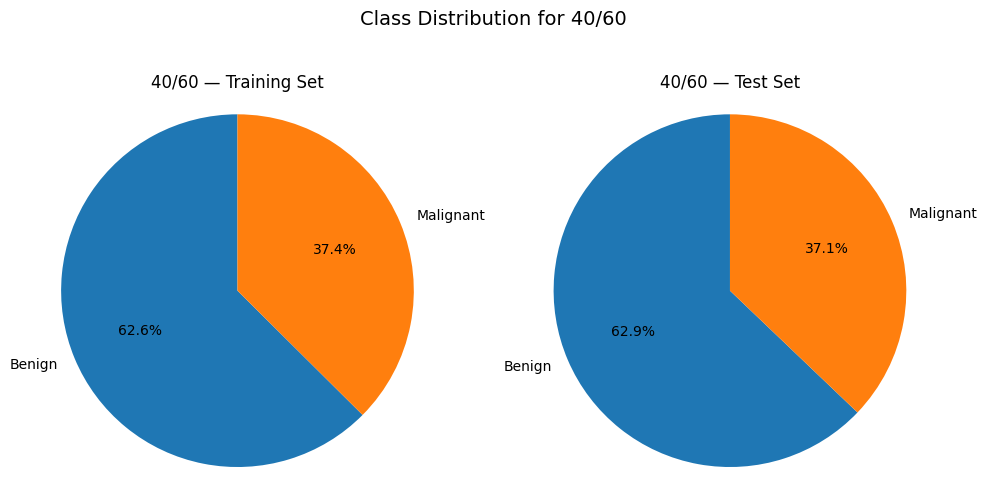

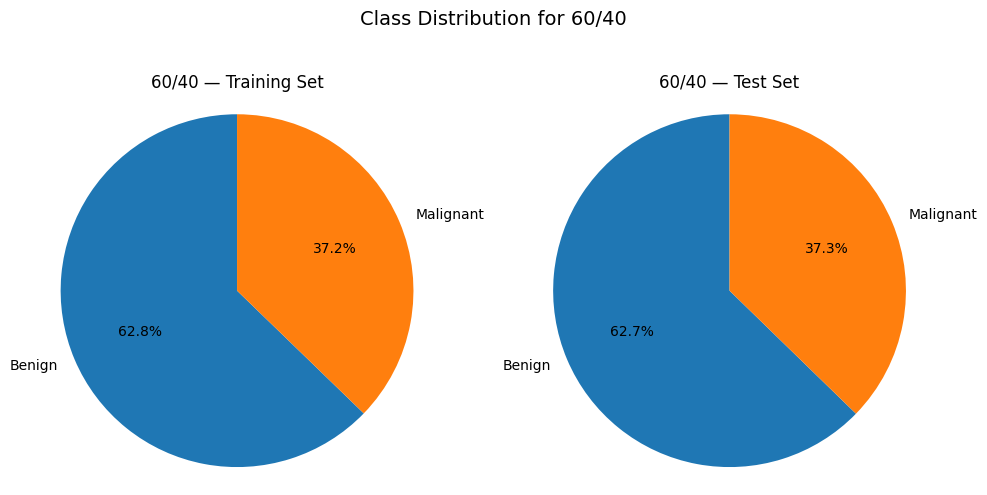

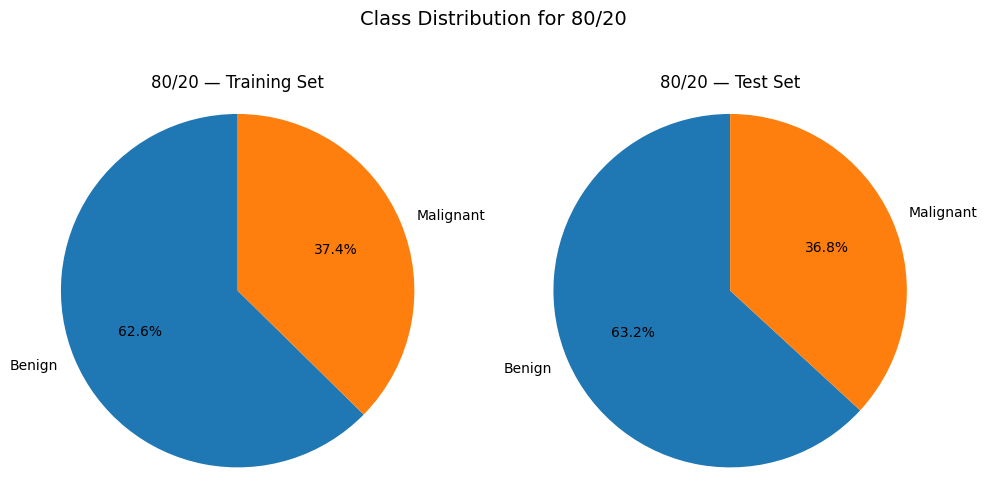

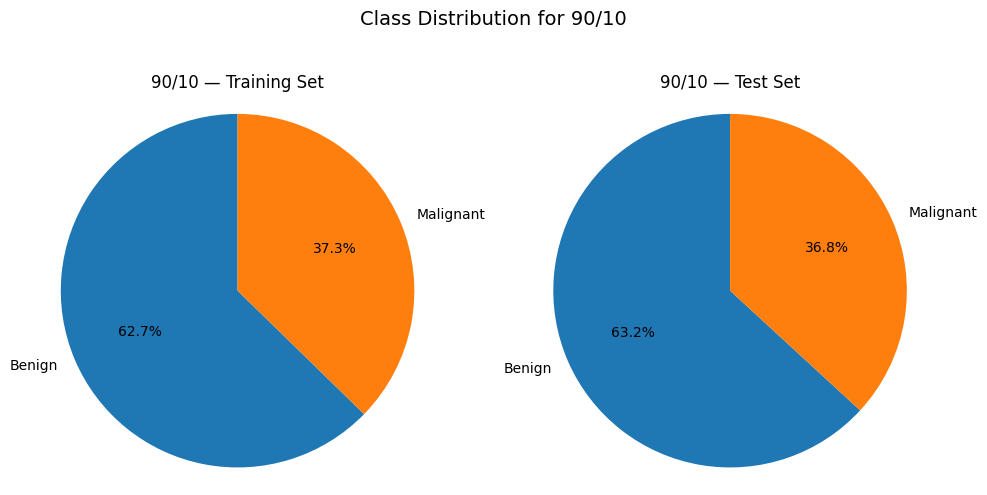

In [28]:
# Visualize the class distribution in each split
for name, subset in breastcancer_slipt.items():
    ct_train = np.bincount(subset["label_train"], minlength=2)
    ct_test = np.bincount(subset["label_test"], minlength=2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].pie(ct_train, labels=label_names, autopct='%1.1f%%', startangle=90)
    axes[0].set_title(f"{name} — Training Set")
    axes[0].axis('equal')    
    
    axes[1].pie(ct_test, labels=label_names, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f"{name} — Test Set")
    axes[1].axis('equal')
    
    fig.suptitle(f"Class Distribution for {name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# BUILDING THE DESICION TREE CLASSIFIERS

In [29]:
#Train a Decision Tree Classifier
def training(feature_train, label_train, depth=None):
    dt_classifier = sklearn.tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=depth
    )
    dt_classifier.fit(feature_train, label_train)
    
    return dt_classifier

In [30]:
#Building Decision Tree
def building(dt_classifier, features, labels):
    dot_data = sklearn.tree.export_graphviz(
        dt_classifier,
        out_file=None,
        feature_names=features,
        class_names=labels,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

Decision Tree for 40/60 Split


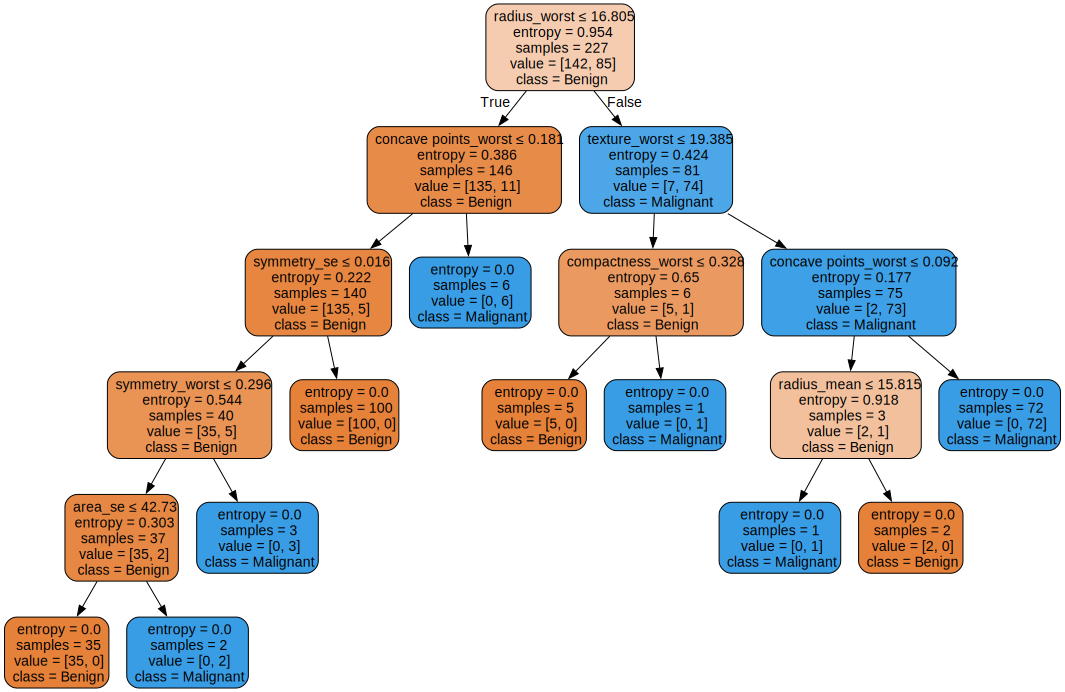

Decision Tree for 60/40 Split


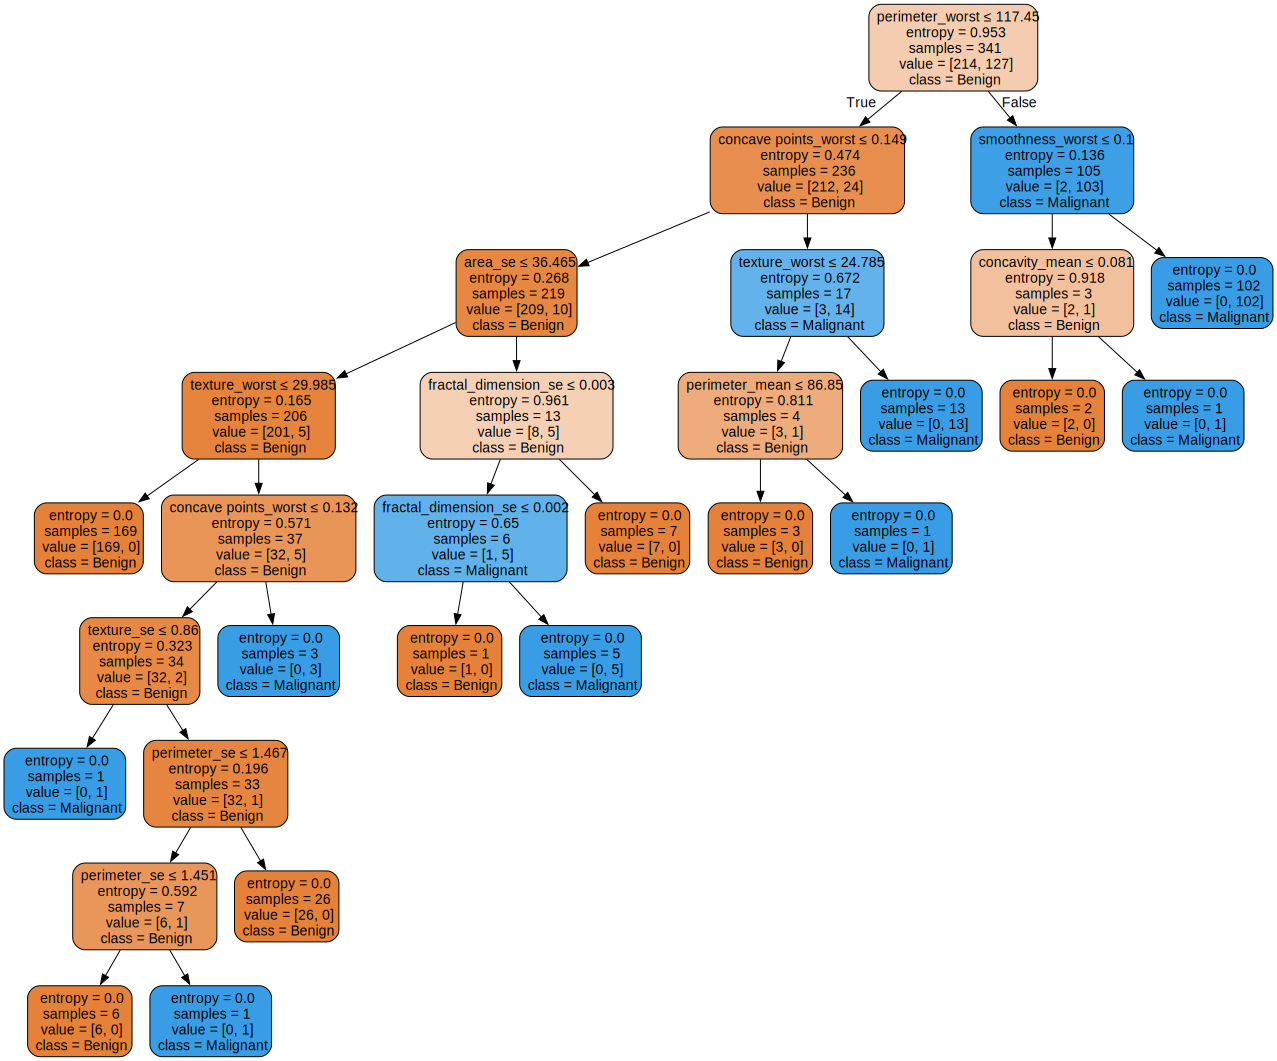

Decision Tree for 80/20 Split


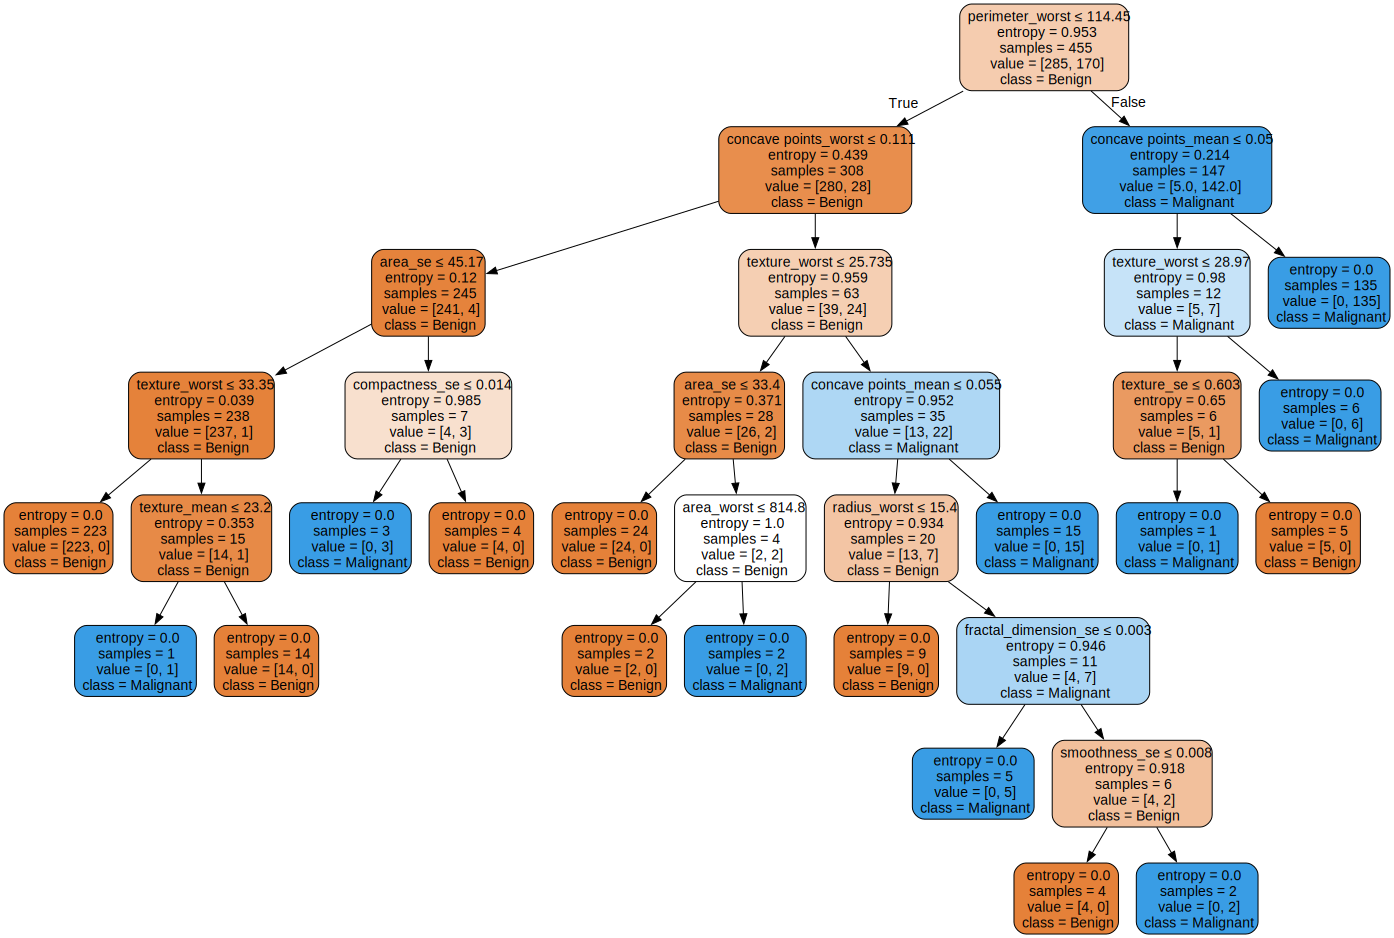

Decision Tree for 90/10 Split


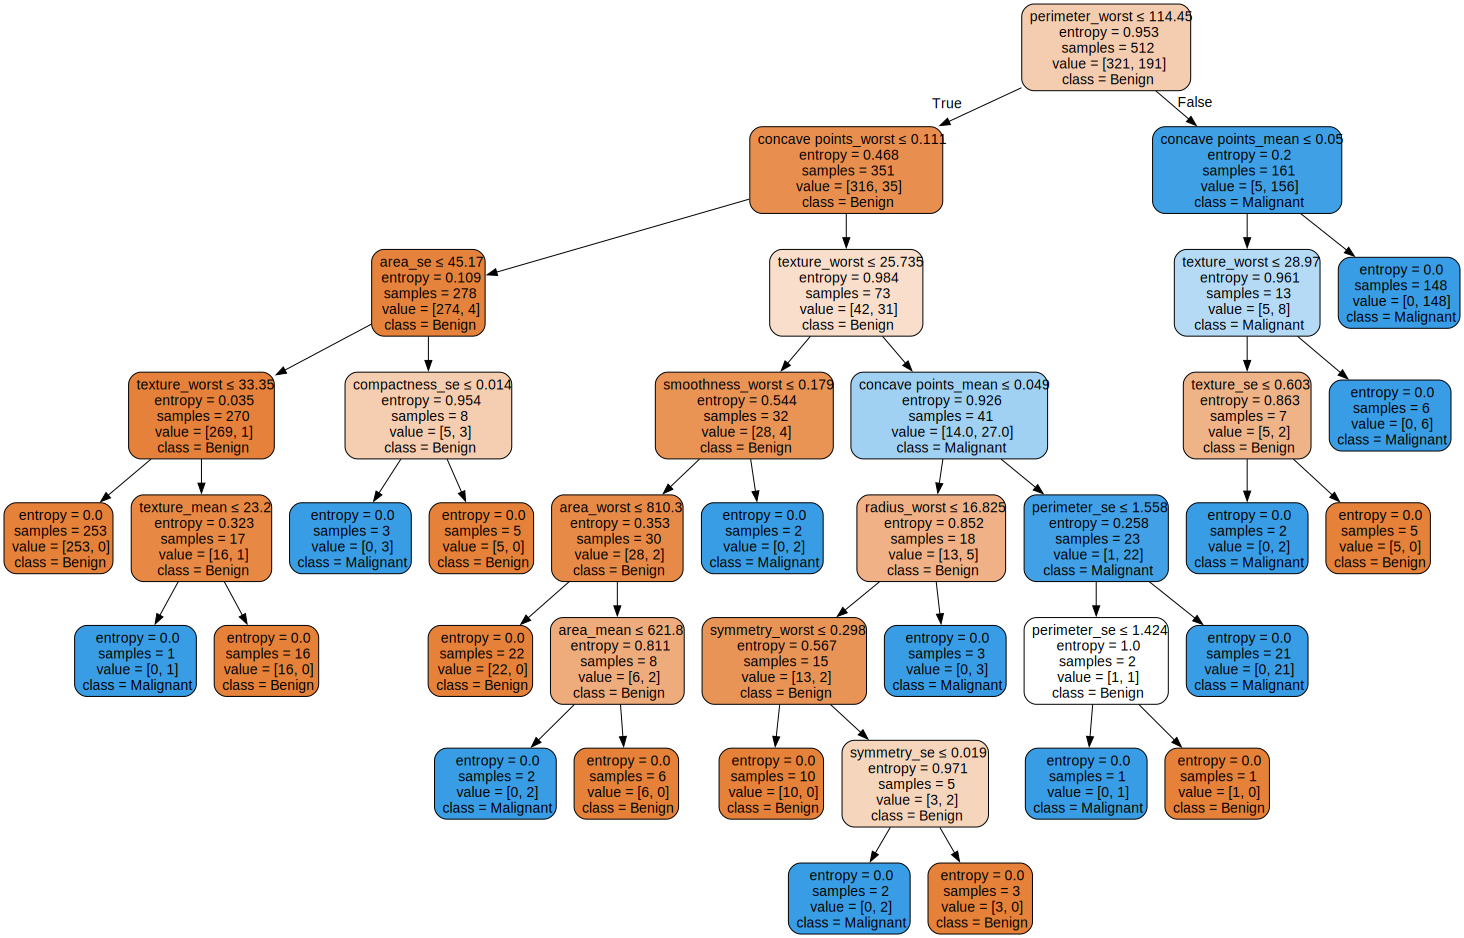

In [31]:
#Training and Building Decision Tree for each split
breastcancer_models = {}
for name, data in breastcancer_slipt.items():
    model = training(data["feature_train"], data["label_train"])
    breastcancer_models[name] = model
    graph = building(model, feature_names, label_names)

    print(f"Decision Tree for {name} Split")
    display(graph)
    

# CLASSIFICATION REPORT AND CONFUSION TREE


Evaluating split: 40/60
Classification Report
              precision    recall  f1-score   support

      Benign       0.91      0.96      0.93       215
   Malignant       0.92      0.83      0.88       127

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.90       342
weighted avg       0.91      0.91      0.91       342



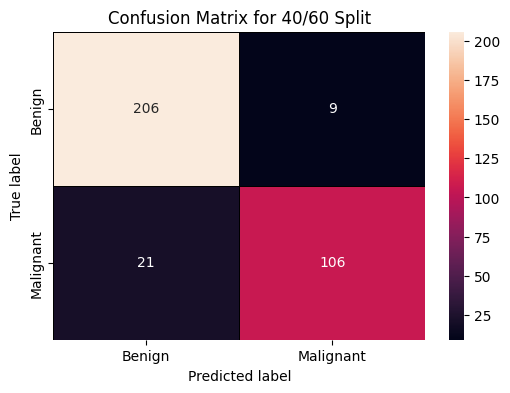


Evaluating split: 60/40
Classification Report
              precision    recall  f1-score   support

      Benign       0.94      0.96      0.95       143
   Malignant       0.93      0.91      0.92        85

    accuracy                           0.94       228
   macro avg       0.94      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



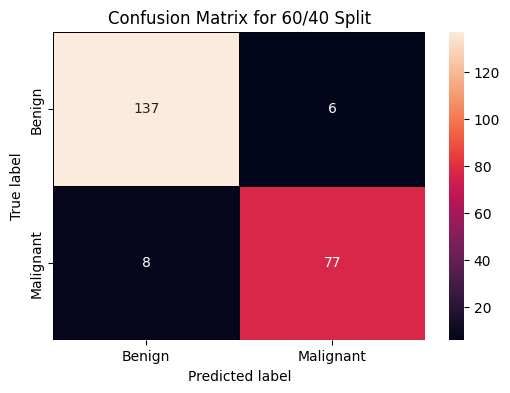


Evaluating split: 80/20
Classification Report
              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97        72
   Malignant       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



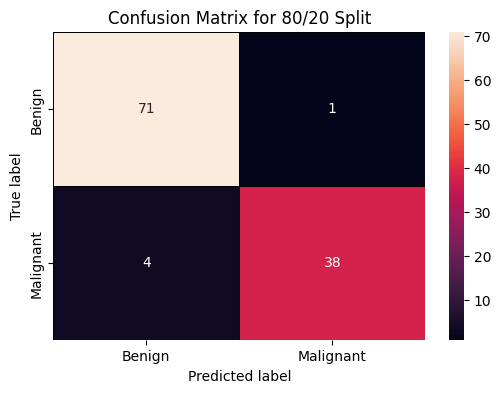


Evaluating split: 90/10
Classification Report
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96        36
   Malignant       0.95      0.90      0.93        21

    accuracy                           0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57



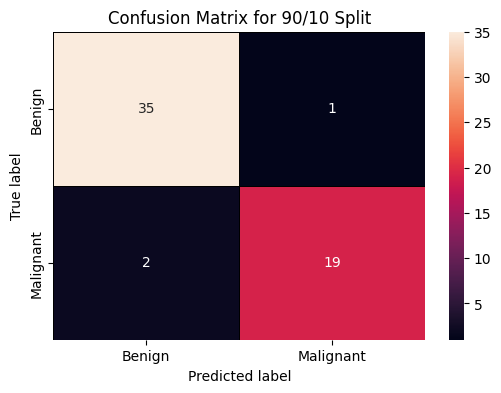

In [32]:
evaluating_results = {}
for name, data in breastcancer_slipt.items():
    model = breastcancer_models[name]
    feature_test = data["feature_test"]
    true_labels = data["label_test"]

    predicted_labels = model.predict(feature_test)
    accuracy = sklearn.metrics.accuracy_score(true_labels, predicted_labels)
    report = sklearn.metrics.classification_report(true_labels, predicted_labels, target_names=label_names)
    matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

    evaluating_results[name] = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": matrix,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels
    }

    print(f"\nEvaluating split: {name}")
    print("Classification Report")
    print(report)
    
    plt.figure(figsize=(6, 4))
    seaborn.heatmap(matrix, annot=True, fmt='d', cmap='rocket', 
                xticklabels=label_names, yticklabels=label_names,
                linewidths=.5, linecolor='black') 
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {name} Split')
    plt.show()

# THE DEPTH AND ACCURACY OF A DECISION TREE


 Decision tree với Max Depth là None


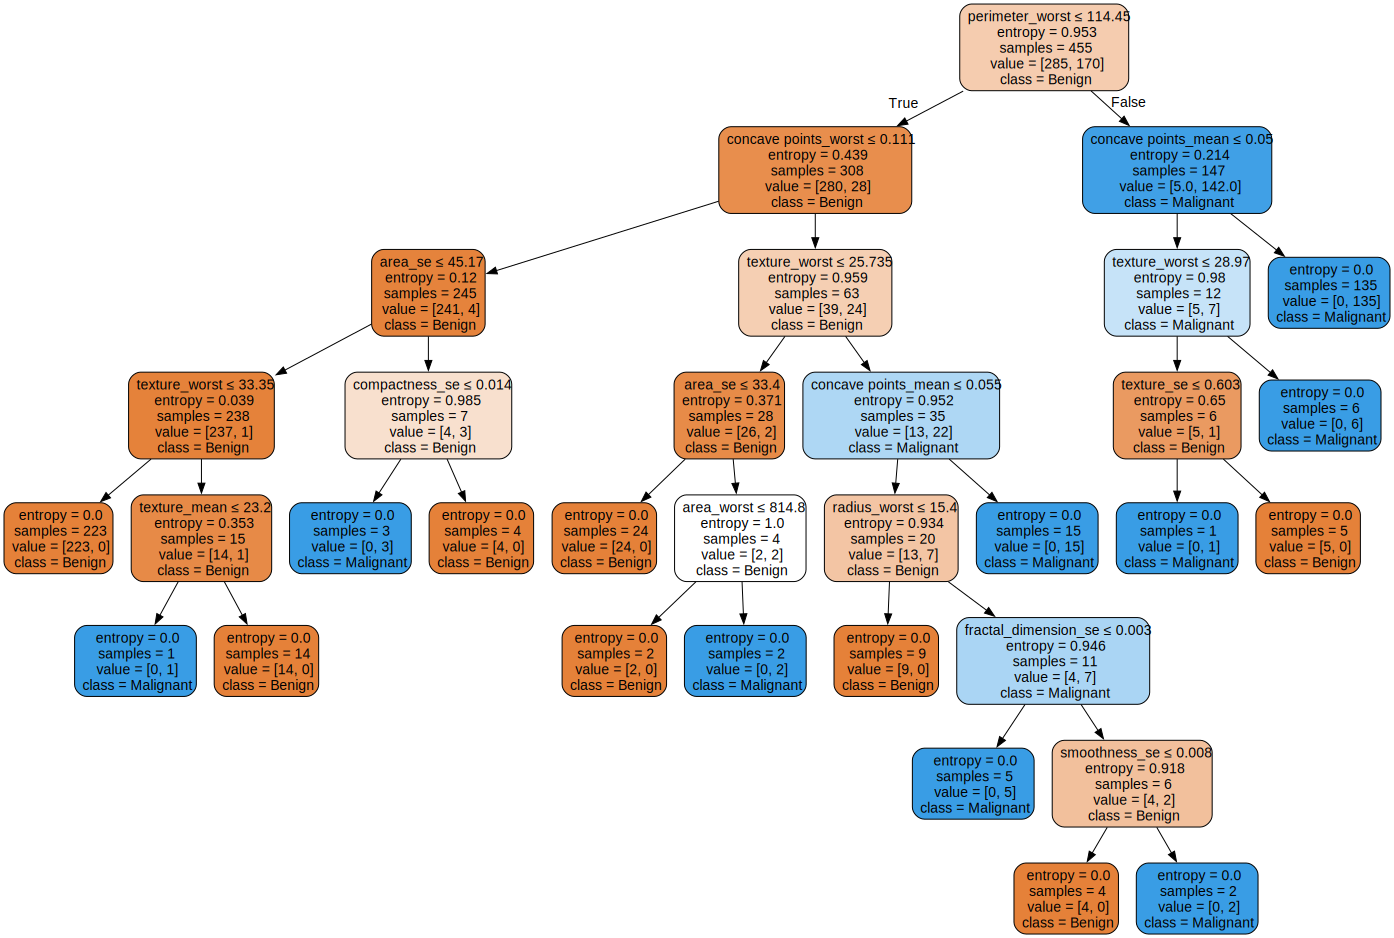


 Decision tree với Max Depth là 2


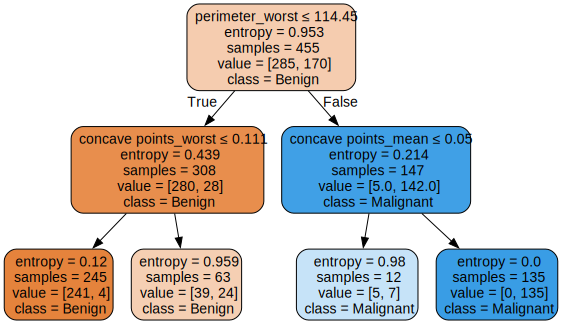


 Decision tree với Max Depth là 3


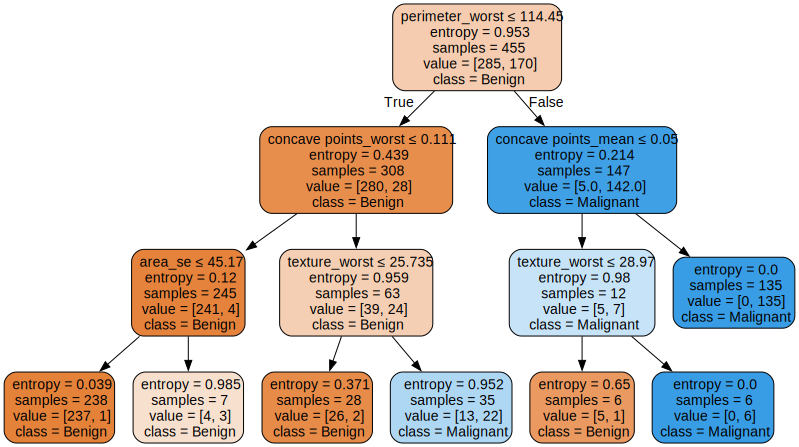


 Decision tree với Max Depth là 4


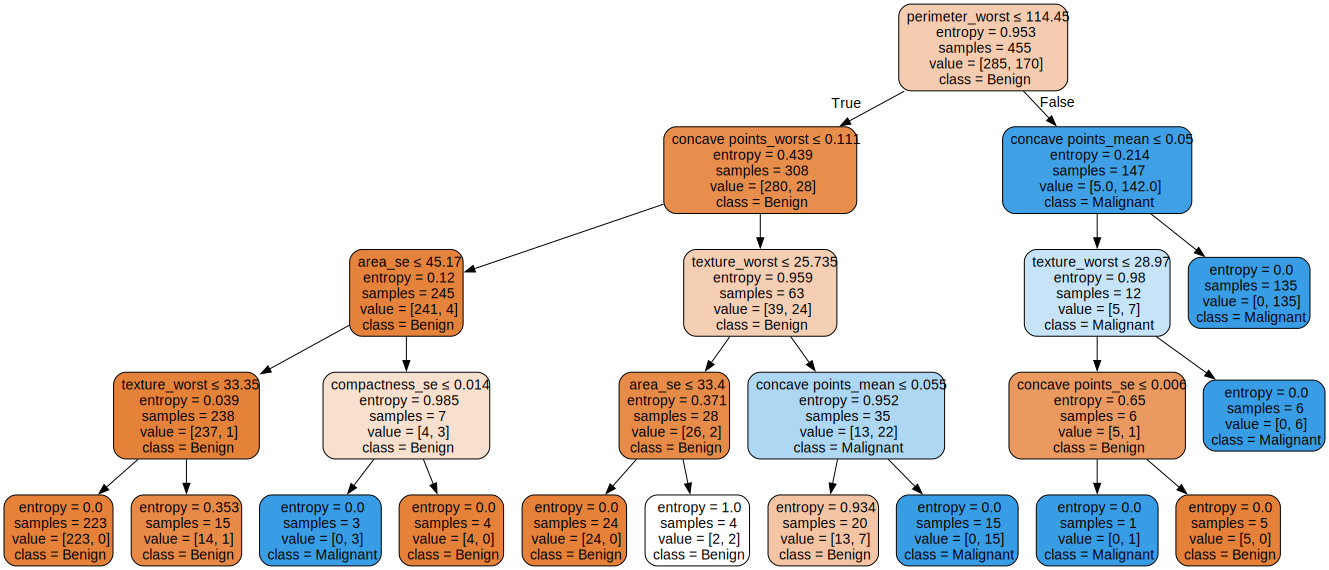


 Decision tree với Max Depth là 5


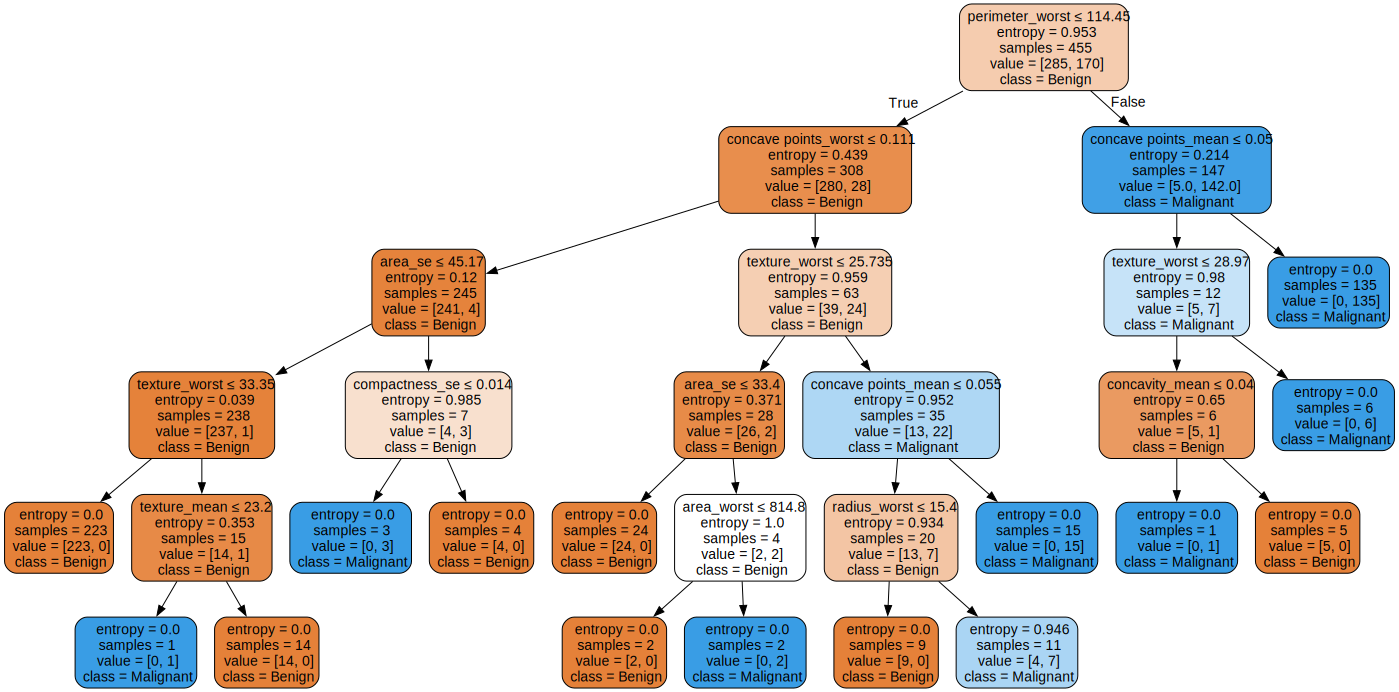


 Decision tree với Max Depth là 6


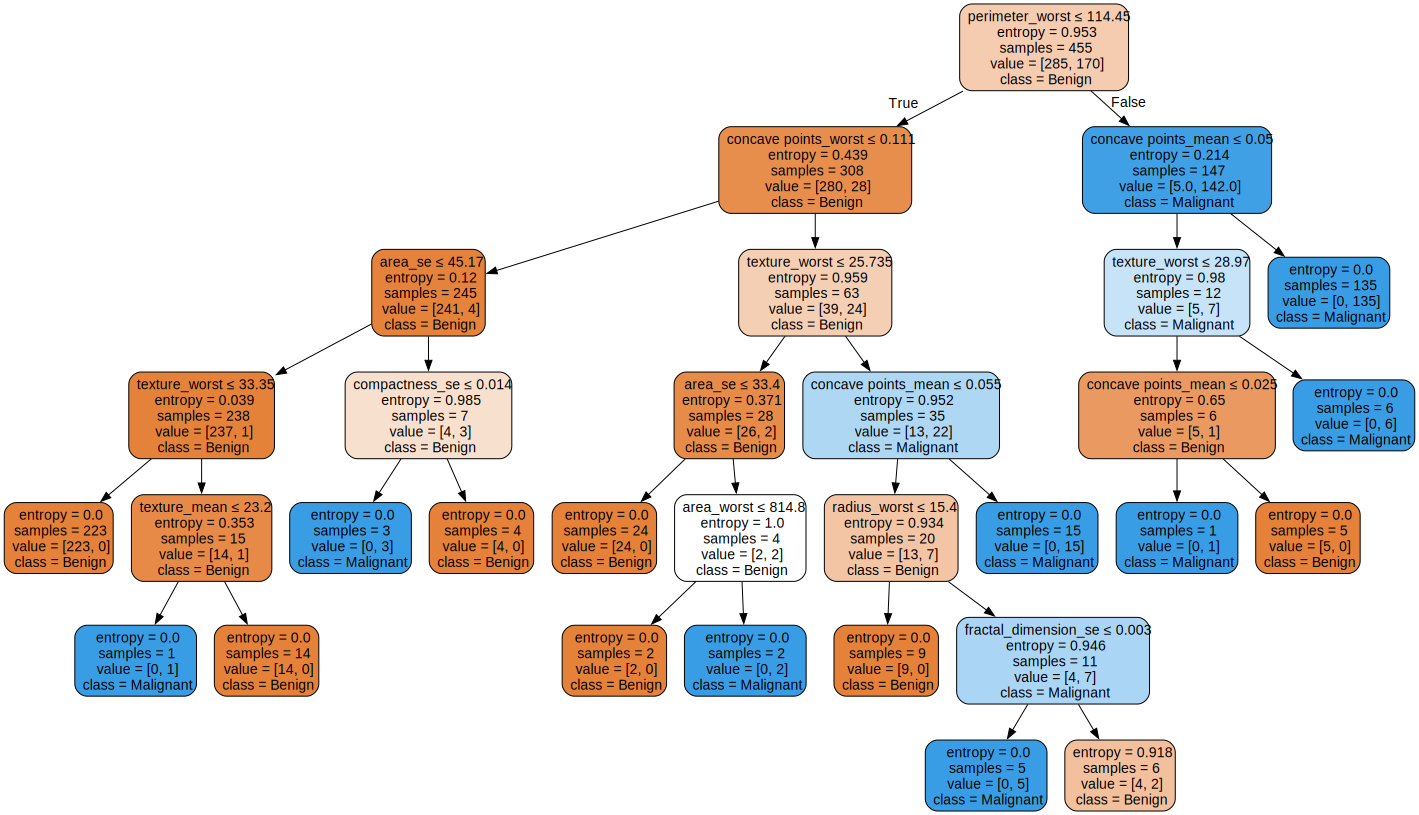


 Decision tree với Max Depth là 7


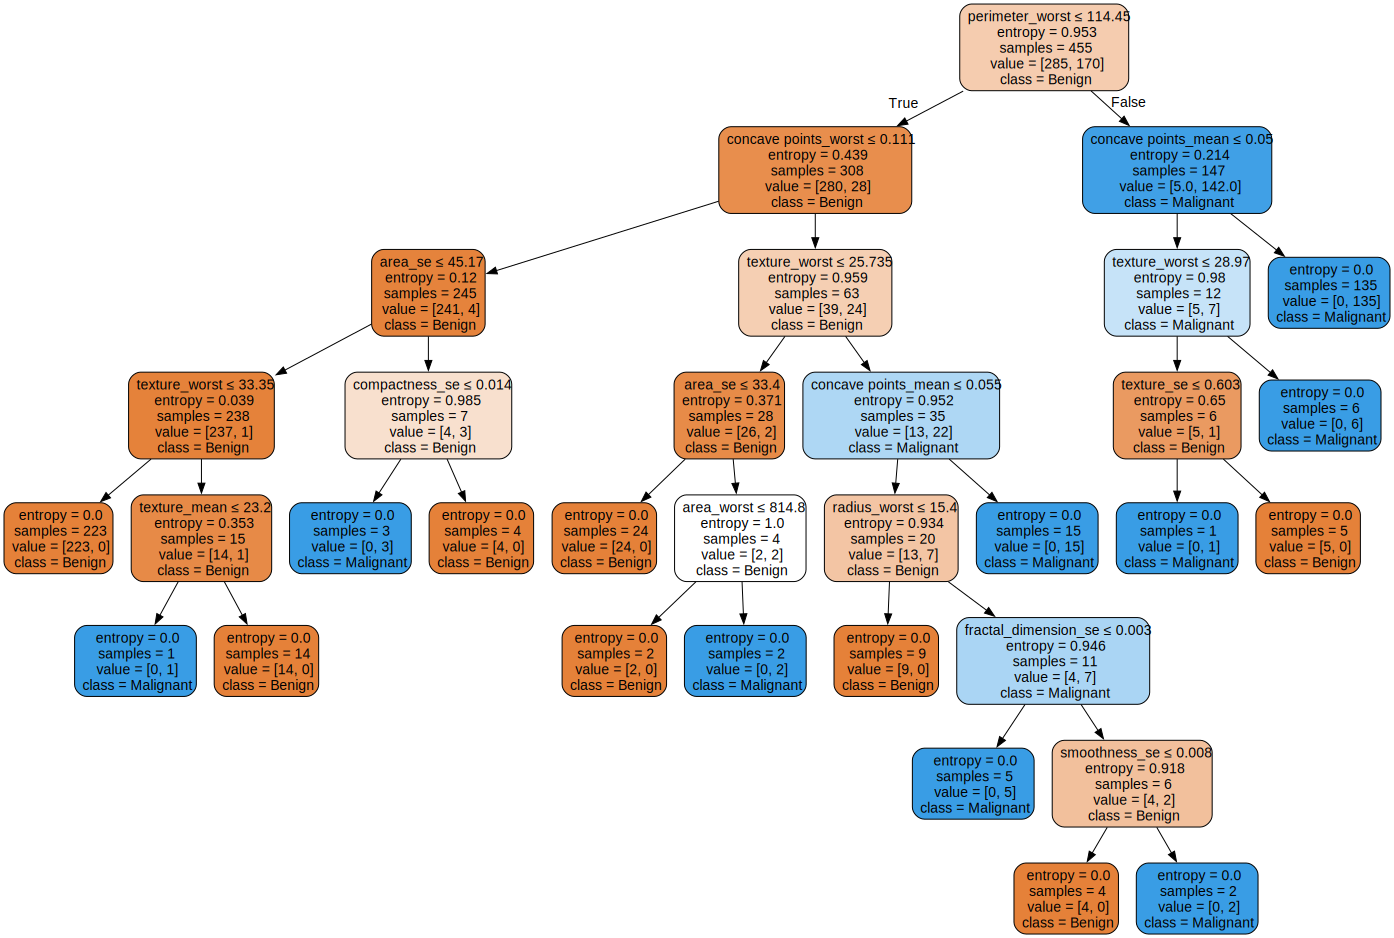

In [33]:
feature_train, feature_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features, labels,
    test_size=0.2,        
    random_state=42,
    shuffle = True,
    stratify=labels       
)

max_depths = [None, 2, 3, 4, 5, 6, 7]
accuracy_8020 = {}

for depth in max_depths:
    #training
    dt_classifier = training(feature_train, label_train, depth)

    #build decision tree
    graph = building(dt_classifier, feature_names, label_names)
    print(f"\n Decision tree với Max Depth là {depth}")
    display(graph)

    #Calculate the accuracy
    predicted_labels = dt_classifier.predict(feature_test)
    accuracy = sklearn.metrics.accuracy_score(label_test, predicted_labels)
    accuracy_8020[str(depth)] = accuracy
    

In [34]:
#Table accuracy
print("Max_depth:\t Accuracy")
for name, data in accuracy_8020.items():
    print(f"\n{name}: \t\t{data}")

Max_depth:	 Accuracy

None: 		0.956140350877193

2: 		0.8859649122807017

3: 		0.9385964912280702

4: 		0.9298245614035088

5: 		0.956140350877193

6: 		0.9298245614035088

7: 		0.956140350877193
